In [112]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap
import yfinance

from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mplfinance.original_flavor import candlestick_ohlc


In [113]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self

In [114]:
Notebook_timer = MeasureTime()
Notebook_timer.kill()

Time elapsed: 00:00:00


In [115]:

def get_stock_dataframe(ticker , startDate , endDate):
  #Get the stock
  df = datard.DataReader(ticker, 'stooq', startDate, endDate , '1h')
  #Reverse the data frame
  df = df.iloc[::-1]
  return df
  
ticker = 'AAPL'
endDate = pd.to_datetime('today')
startDate = endDate - timedelta(days = 365 * 32 )

df = yfinance.download(ticker , startDate , endDate )
# df = get_stock_dataframe(ticker , startDate , endDate , i)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-03-19,0.361607,0.379464,0.357143,0.378348,0.303668,431793600
1990-03-20,0.377232,0.383929,0.363839,0.369420,0.296503,391316800
1990-03-21,0.368304,0.377232,0.368304,0.371652,0.298294,152734400
1990-03-22,0.372768,0.377232,0.363839,0.363839,0.292023,231660800
1990-03-23,0.368304,0.383929,0.366071,0.377232,0.302773,227987200
...,...,...,...,...,...,...
2022-03-04,164.490005,165.550003,162.100006,163.169998,163.169998,83737200
2022-03-07,163.360001,165.020004,159.039993,159.300003,159.300003,96418800
2022-03-08,158.820007,162.880005,155.800003,157.440002,157.440002,131148300


In [116]:
del df['Adj Close']
del df['Volume']

In [117]:
#Timestep = List of candles seqeuence
# Items = Candlestick
# Features = High, Low, Open, Close parametes
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]

    date = range(len(closep))

    x = 0
    y = len(date)
    ohlc = []

    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x += 1

    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
        
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


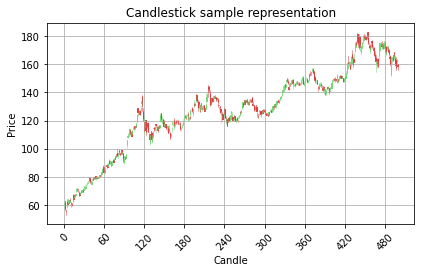

In [118]:
graph_data_ohlc(df.tail(500).values)

In [119]:
#Custom generator function to create 3d arrays of candles sequence
#We will look for patterns based on the last 3 candles. 
#To do so, we need to change the format of our dataset to 3 dimensional array (Timestep, Items, Features) .
def my_generator(data,lookback):
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row: first_row + lookback]:
            temp_list.append(candle)
            
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row + 1
    return arr

In [120]:
df.values[0:],3

(array([[  0.36160699,   0.379464  ,   0.35714301,   0.37834799],
        [  0.37723199,   0.38392901,   0.363839  ,   0.36941999],
        [  0.36830401,   0.37723199,   0.36830401,   0.37165201],
        ...,
        [158.82000732, 162.88000488, 155.80000305, 157.44000244],
        [161.47999573, 163.41000366, 159.41000366, 162.94999695],
        [160.19999695, 160.38999939, 155.97999573, 158.52000427]]),
 3)

In [121]:
cell_timer = MeasureTime()
three_dim_sequence = np.asarray(my_generator(df.values[0:],3))
cell_timer.kill()

Time elapsed: 00:00:00


In [122]:
three_dim_sequence.shape

(8056, 3, 4)

Step 1


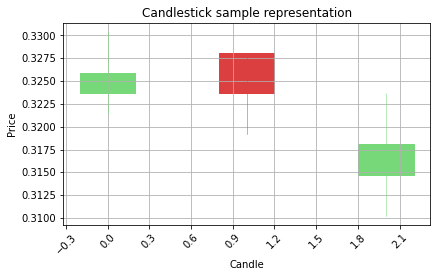

Step 2


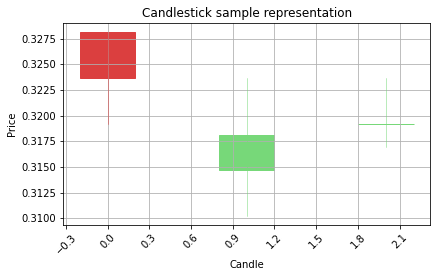

Step 3


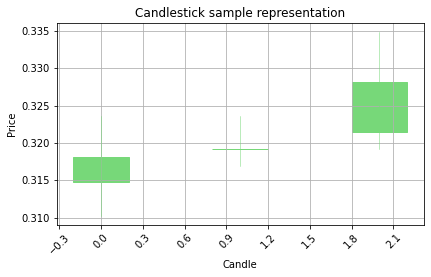

Step 4


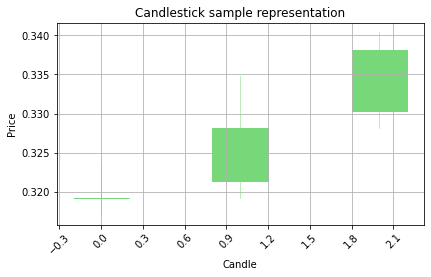

Step 5


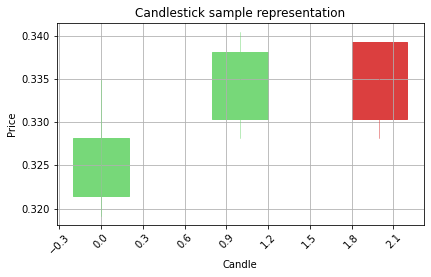

In [123]:
counter=0
for candle in three_dim_sequence[1000:1005]:
    counter=counter+1
    print('Step ' + str(counter))
    graph_data_ohlc(candle)

In [124]:
# convert the price data in to actual candlestick parameters. Each candle has 4 parameters
# Open	High Low	Close -< conversion_array
# Size of the body measured by pips
# Size of the upper wicks measured by pips
# Size of the lower wicks measured by pips
# Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000, 4)
    candlestick_data[2]=round(round(wicks_down,5)*10000, 4)
    candlestick_data[3]=round(round(body_size,5)*10000, 4)

    return candlestick_data

In [125]:
cell_timer = MeasureTime()
one_candle_data_ohlc=three_dim_sequence[1000:1010][5][1]
cell_timer.kill()

Time elapsed: 00:00:00


In [126]:
one_candle_data_ohlc

array([0.339286  , 0.339286  , 0.328125  , 0.33035699])

In [127]:
one_candle_data_ohlc_candle=ohlc_to_candlestick(one_candle_data_ohlc)

In [128]:
one_candle_data_ohlc_candle

[0, 0.0, 22.3, 89.3]

In [129]:
#Apply this function in to generator function to get sequences with candlestick data instead of OHLC data
def my_generator_candle(data,lookback):
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [130]:
three_dim_sequence_candle=my_generator_candle(df.values[1:],3)
three_dim_sequence_candle[1000:1005]

array([[[ 0. ,  0. , 44.7, 44.6],
        [ 1. , 55.8, 44.6, 33.5],
        [ 0. , 44.7, 22.3, 44.7]],

       [[ 1. , 55.8, 44.6, 33.5],
        [ 0. , 44.7, 22.3, 44.7],
        [ 1. , 67. , 22.3, 67. ]],

       [[ 0. , 44.7, 22.3, 44.7],
        [ 1. , 67. , 22.3, 67. ],
        [ 1. , 22.3, 22.3, 78.1]],

       [[ 1. , 67. , 22.3, 67. ],
        [ 1. , 22.3, 22.3, 78.1],
        [ 0. ,  0. , 22.3, 89.3]],

       [[ 1. , 22.3, 22.3, 78.1],
        [ 0. ,  0. , 22.3, 89.3],
        [ 1. ,  0. , 55.8, 78.1]]])

In [131]:
#arr : converted data array using ohlc_to_candlestick
# arr3 : raw data array
# arr2: preditcion
def my_generator_candle_X_Y(data,lookback,MinMax = False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))

    arr3 = np.empty((0,lookback,4))
    
    Y_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)

        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)
        
        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:
            arr = np.append(arr, templist4, axis=0)

        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])

        Prediction = converted_data_prediction[0]
        Y_list.append(Prediction)

        first_row=first_row + 1

    arr2 = np.asarray(Y_list)

    return arr,arr2,arr3

In [132]:
# X : converted data array using ohlc_to_candlestick
# X_raw : raw data array
# Y: preditcion
cell_timer = MeasureTime()
X,Y, X_raw = my_generator_candle_X_Y(df.values,3,MinMax=False)
cell_timer.kill()

Time elapsed: 00:00:01


In [133]:
unique, counts = np.unique(Y, return_counts=True)
predictions_type = dict(zip(unique, counts))
print('Bull: ' + str((predictions_type[1])) + ' percent: ' + str(round((predictions_type[1]*100)/len(Y),2)) + '%')
print('Bear: ' + str((predictions_type[0])) + ' percent: ' + str(round((predictions_type[0]*100)/len(Y),2)) + '%')
print('Total: ' + str(len(Y)))

Bull: 3955 percent: 49.1%
Bear: 4100 percent: 50.9%
Total: 8055


In [134]:
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

Shape of X (8055, 3, 4)
Shape of Y (8055,)
Shape of X raw ohlc (8055, 3, 4)


In [135]:
unique, counts = np.unique(Y, return_counts=True)
predictions_type = dict(zip(unique, counts))
print('Bull: ' + str((predictions_type[1])) + ' percent: ' + str(round((predictions_type[1]*100)/len(Y),2)) + '%')
print('Bear: ' + str((predictions_type[0])) + ' percent: ' + str(round((predictions_type[0]*100)/len(Y),2)) + '%')
print('Total: ' + str(len(Y)))


Bull: 3955 percent: 49.1%
Bear: 4100 percent: 50.9%
Total: 8055


Correct prediction would be Bullish ---^


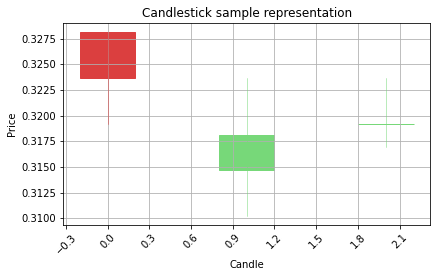

Correct prediction would be Bullish ---^


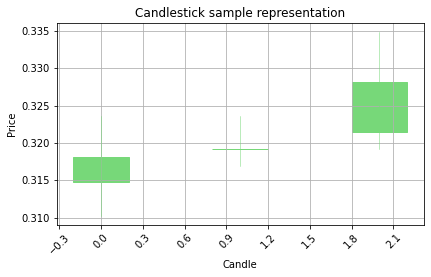

Correct prediction would be Bearish ---v


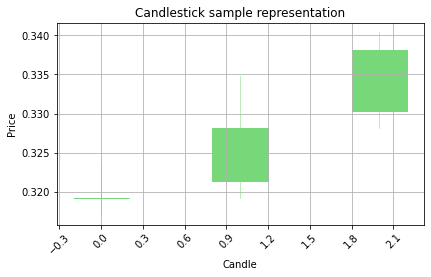

Correct prediction would be Bullish ---^


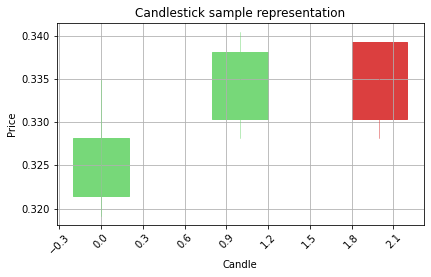

Correct prediction would be Bearish ---v


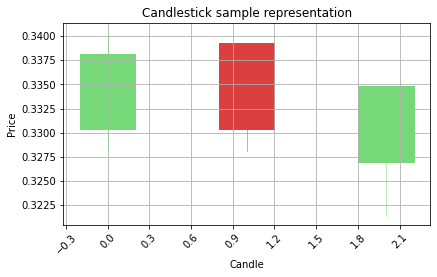

In [136]:
for a in range(5):
    b=a+1000
    if Y[b] == 1:print('Correct prediction would be Bullish ---^')
    if Y[b] == 0:print('Correct prediction would be Bearish ---v')
    graph_data_ohlc(X_raw[b])

In [137]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(layers.LSTM(units = 50,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(Dropout(0.1))
model.add(layers.LSTM(units = 50))
model.add(Dropout(0.1))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [138]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 50)          11000     
                                                                 
 dropout_6 (Dropout)         (None, None, 50)          0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,251
Trainable params: 31,251
Non-trainable params: 0
_________________________________________________________________


In [139]:
cell_timer = MeasureTime()
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

X_train_raw, X_val_and_test_raw= train_test_split(X_raw, test_size=0.5)
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5)
cell_timer.kill()

Time elapsed: 00:00:00


In [156]:
Y_val_and_test.shape

(4028,)

In [140]:
print('Training data: ' + 'X Input shape: ' + str(X_train.shape) + ', ' + 'Y Output shape: ' + str(Y_train.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Validation data: ' + 'X Input shape: ' + str(X_val.shape) + ', ' + 'Y Output shape: ' + str(Y_val.shape) + ', ' + 'datetime shape: ' + str(Y_val.shape))
print('Test data: ' + 'X Input shape: ' + str(X_test.shape) + ', ' + 'Y Output shape: ' + str(Y_test.shape) + ', ' + 'datetime shape: ' + str(Y_test.shape))

Training data: X Input shape: (4027, 3, 4), Y Output shape: (4027,), datetime shape: (4027,)
Validation data: X Input shape: (2014, 3, 4), Y Output shape: (2014,), datetime shape: (2014,)
Test data: X Input shape: (2014, 3, 4), Y Output shape: (2014,), datetime shape: (2014,)


In [141]:
X_train.shape

(4027, 3, 4)

In [142]:
cell_timer = MeasureTime()
history = model.fit(X_train, Y_train, epochs= 20 ,validation_data=(X_val, Y_val))
cell_timer.kill()

Epoch 1/20
126/126 [==============================] - 4s 9ms/step - loss: 0.6948 - acc: 0.5011 - val_loss: 0.6961 - val_acc: 0.4990
Epoch 2/20
126/126 [==============================] - 0s 4ms/step - loss: 0.6928 - acc: 0.5205 - val_loss: 0.6955 - val_acc: 0.4871
Epoch 3/20
126/126 [==============================] - 0s 4ms/step - loss: 0.6912 - acc: 0.5269 - val_loss: 0.6952 - val_acc: 0.4876
Epoch 4/20
126/126 [==============================] - 0s 4ms/step - loss: 0.6902 - acc: 0.5165 - val_loss: 0.6936 - val_acc: 0.5238
Epoch 5/20
126/126 [==============================] - 0s 4ms/step - loss: 0.6899 - acc: 0.5245 - val_loss: 0.6966 - val_acc: 0.4960
Epoch 6/20
126/126 [==============================] - 0s 4ms/step - loss: 0.6879 - acc: 0.5463 - val_loss: 0.6958 - val_acc: 0.5055
Epoch 7/20
126/126 [==============================] - 0s 4ms/step - loss: 0.6873 - acc: 0.5384 - val_loss: 0.6972 - val_acc: 0.5030
Epoch 8/20
126/126 [==============================] - 0s 4ms/step - loss: 0.

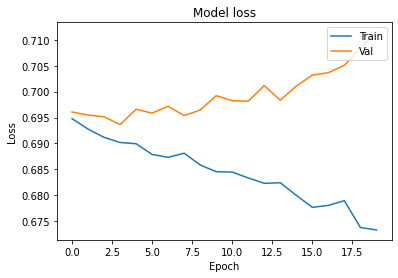

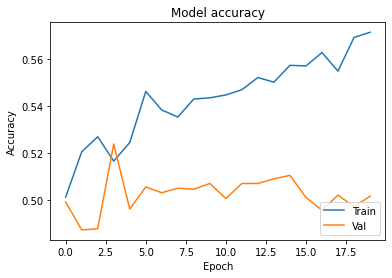

In [143]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [144]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

63/63 [==============================] - 0s 1ms/step - loss: 0.7055 - acc: 0.5124
Test accuracy: 0.5124130845069885


In [146]:
Y_test

array([0, 0, 0, ..., 0, 1, 1])

Correct prediction is Bullish
Model prediction is Bearish
LOST


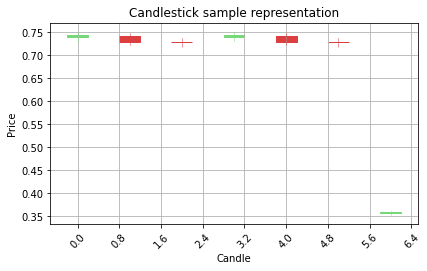

Correct prediction is Bearish
Model prediction is Bearish
WON


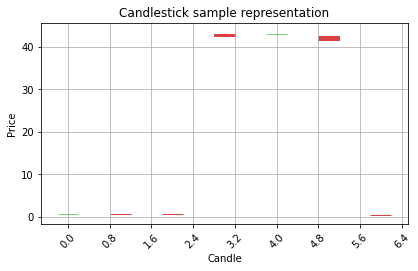

Correct prediction is Bearish
Model prediction is Bullish
LOST


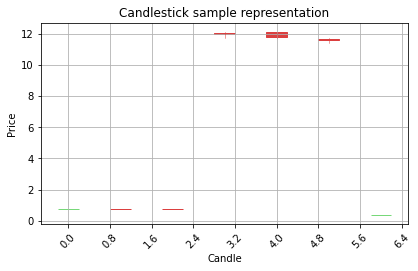

Correct prediction is Bullish
Model prediction is Bullish
WON


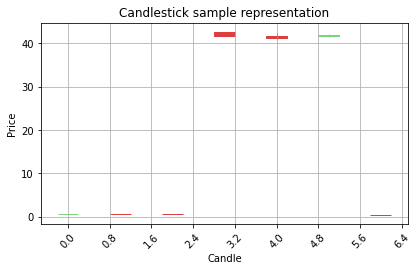

Correct prediction is Bullish
Model prediction is Bearish
LOST


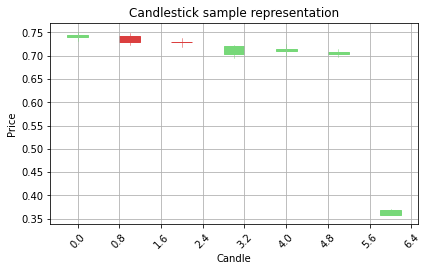

Correct prediction is Bearish
Model prediction is Bullish
LOST


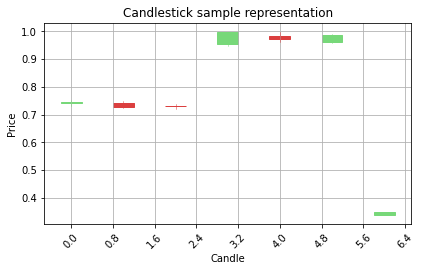

Correct prediction is Bearish
Model prediction is Bearish
WON


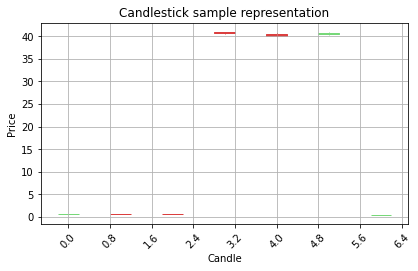

Correct prediction is Bearish
Model prediction is Bullish
LOST


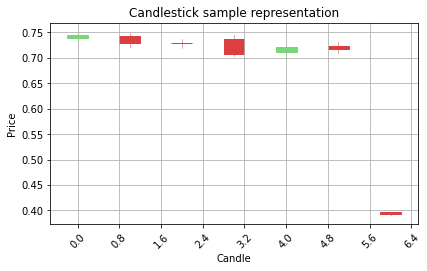

Correct prediction is Bullish
Model prediction is Bullish
WON


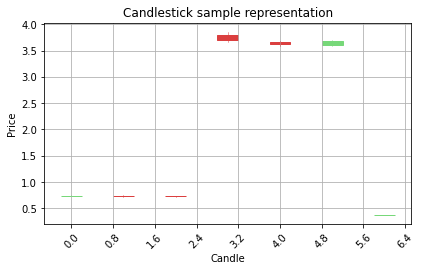

Correct prediction is Bullish
Model prediction is Bearish
LOST


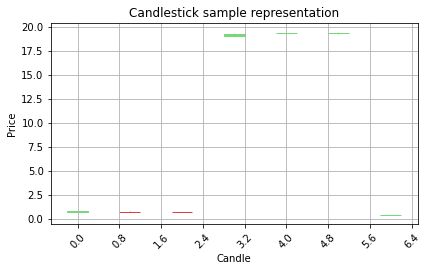

Correct prediction is Bullish
Model prediction is Bullish
WON


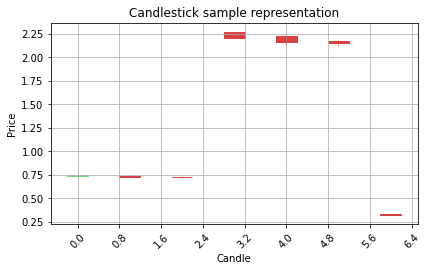

Correct prediction is Bullish
Model prediction is Bullish
WON


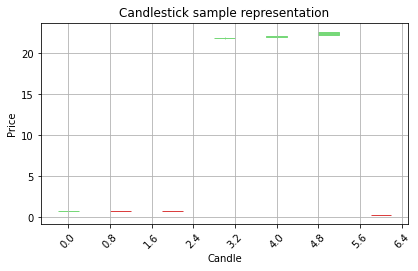

Correct prediction is Bearish
Model prediction is Bullish
LOST


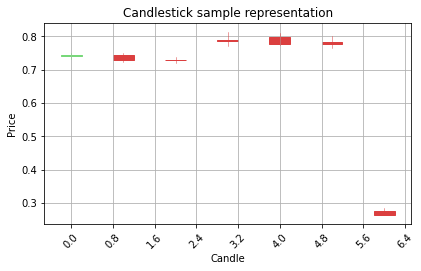

Correct prediction is Bearish
Model prediction is Bearish
WON


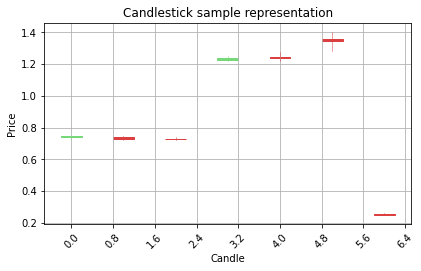

Correct prediction is Bearish
Model prediction is Bullish
LOST


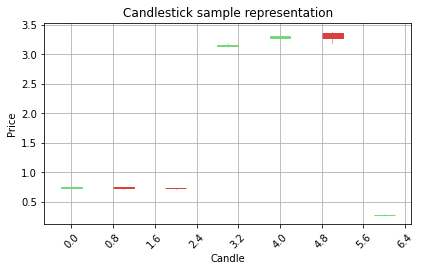

Correct prediction is Bearish
Model prediction is Bearish
WON


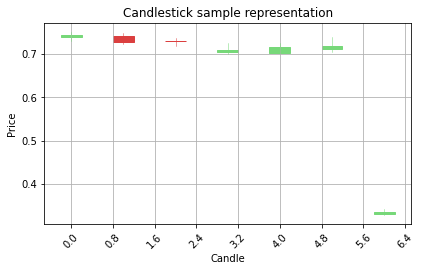

Correct prediction is Bearish
Model prediction is Bearish
WON


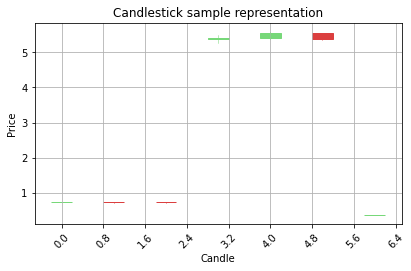

Correct prediction is Bearish
Model prediction is Bullish
LOST


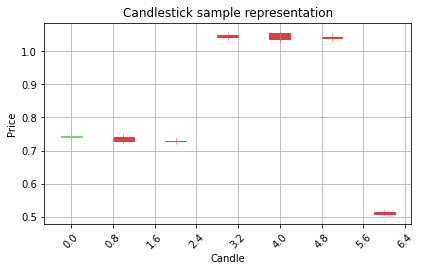

Correct prediction is Bearish
Model prediction is Bullish
LOST


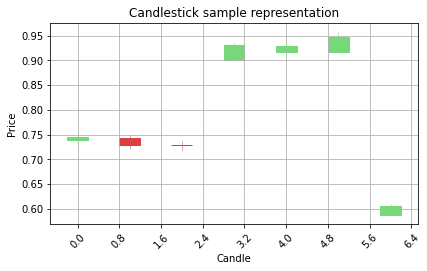

Correct prediction is Bullish
Model prediction is Bearish
LOST


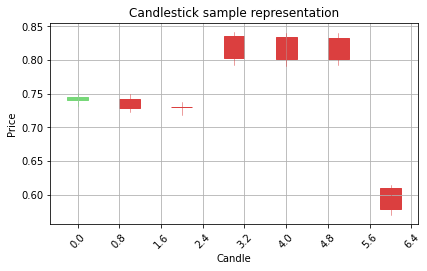

Correct prediction is Bearish
Model prediction is Bearish
WON


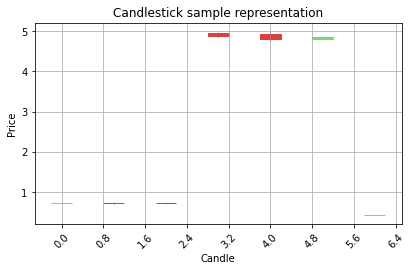

Correct prediction is Bullish
Model prediction is Bullish
WON


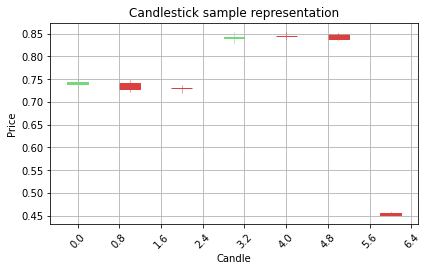

Correct prediction is Bullish
Model prediction is Bearish
LOST


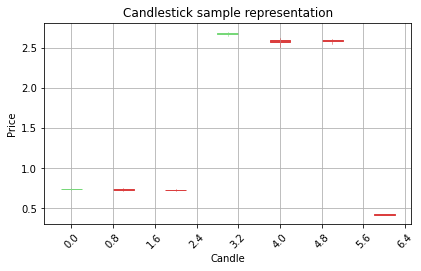

Correct prediction is Bullish
Model prediction is Bearish
LOST


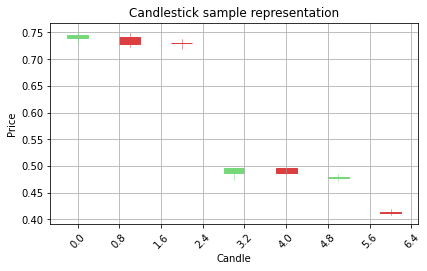

Correct prediction is Bearish
Model prediction is Bullish
LOST


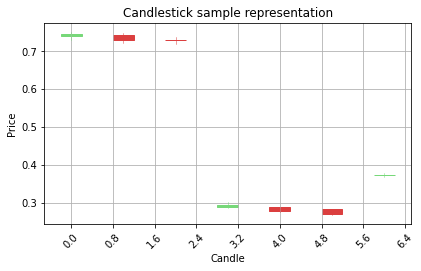

Correct prediction is Bearish
Model prediction is Bearish
WON


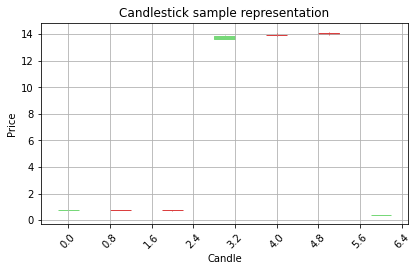

Correct prediction is Bullish
Model prediction is Bullish
WON


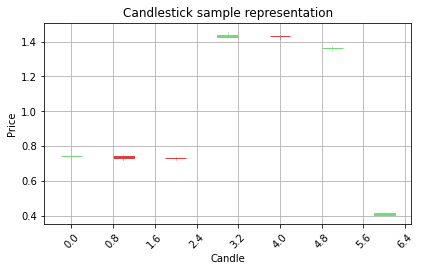

Correct prediction is Bearish
Model prediction is Bearish
WON


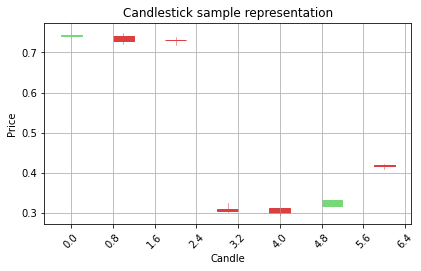

Correct prediction is Bearish
Model prediction is Bullish
LOST


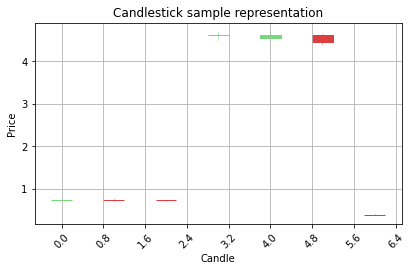

Correct prediction is Bullish
Model prediction is Bearish
LOST


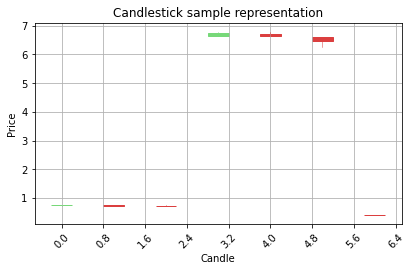

Correct prediction is Bearish
Model prediction is Bullish
LOST


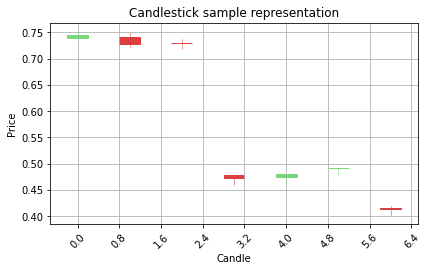

Correct prediction is Bullish
Model prediction is Bullish
WON


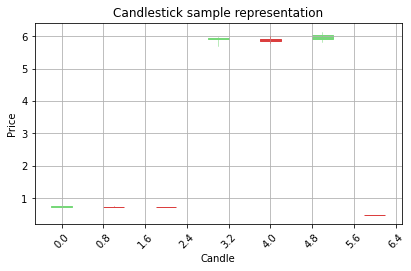

Correct prediction is Bullish
Model prediction is Bullish
WON


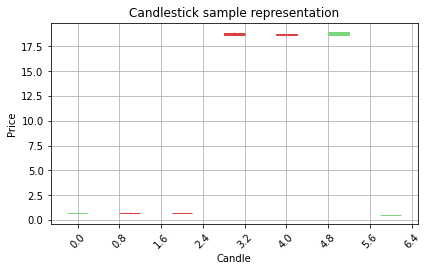

Correct prediction is Bullish
Model prediction is Bearish
LOST


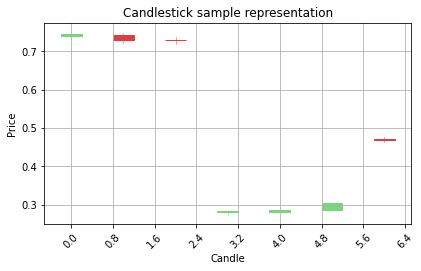

Correct prediction is Bearish
Model prediction is Bearish
WON


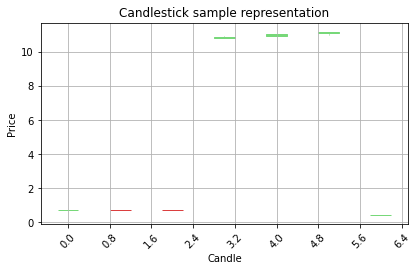

Correct prediction is Bearish
Model prediction is Bullish
LOST


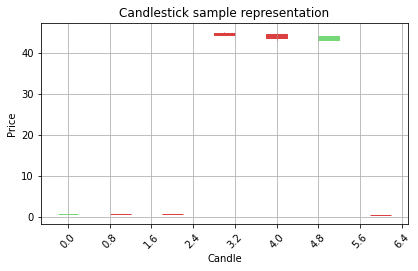

Correct prediction is Bearish
Model prediction is Bearish
WON


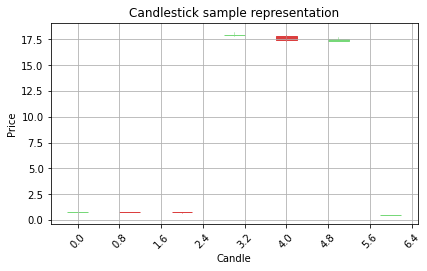

Correct prediction is Bullish
Model prediction is Bullish
WON


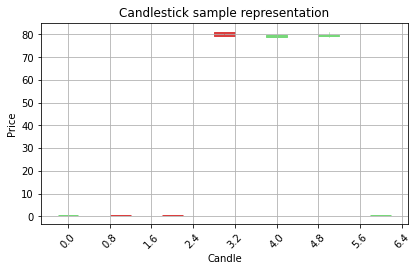

Correct prediction is Bearish
Model prediction is Bullish
LOST


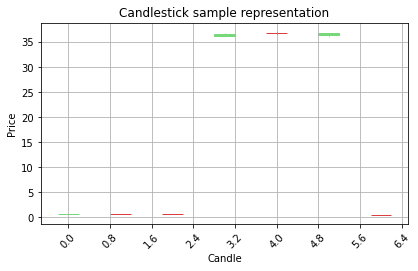

Correct prediction is Bullish
Model prediction is Bearish
LOST


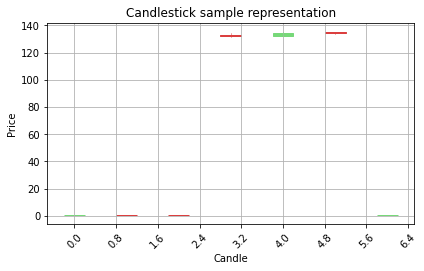

Correct prediction is Bullish
Model prediction is Bearish
LOST


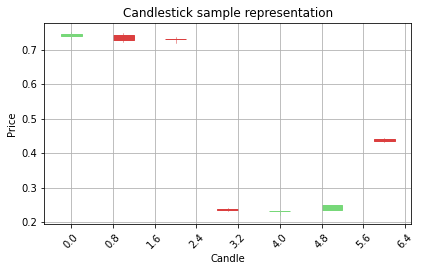

Correct prediction is Bearish
Model prediction is Bearish
WON


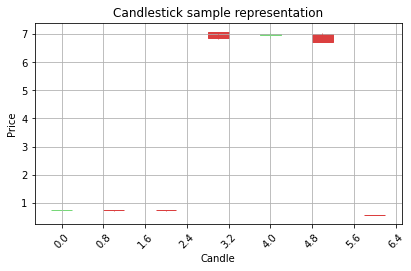

Correct prediction is Bearish
Model prediction is Bullish
LOST


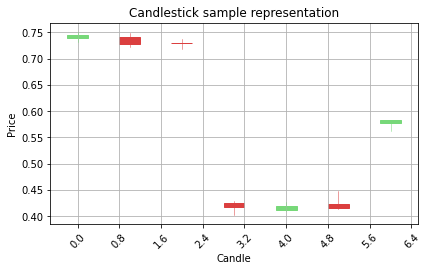

Correct prediction is Bullish
Model prediction is Bearish
LOST


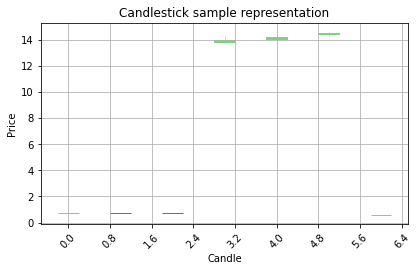

Correct prediction is Bullish
Model prediction is Bullish
WON


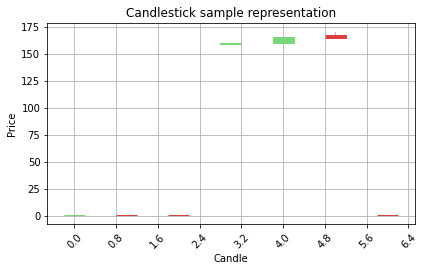

Correct prediction is Bearish
Model prediction is Bearish
WON


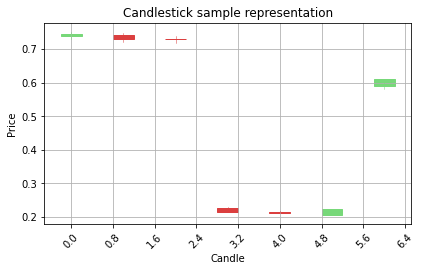

Correct prediction is Bearish
Model prediction is Bearish
WON


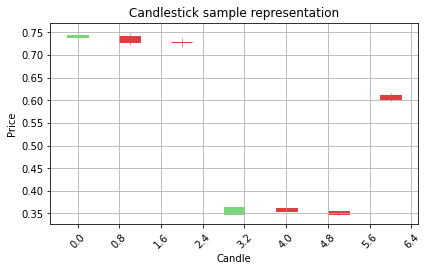

Correct prediction is Bearish
Model prediction is Bearish
WON


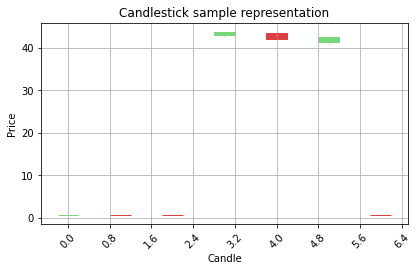

Correct prediction is Bullish
Model prediction is Bearish
LOST


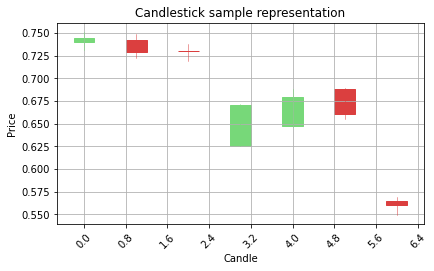

Correct prediction is Bullish
Model prediction is Bearish
LOST


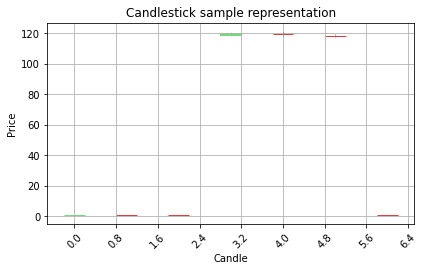

Correct prediction is Bearish
Model prediction is Bullish
LOST


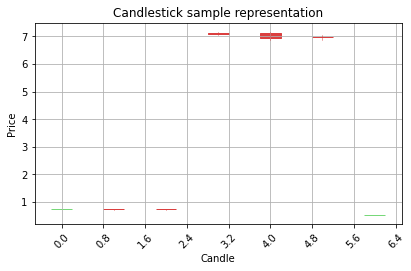

Correct prediction is Bearish
Model prediction is Bearish
WON


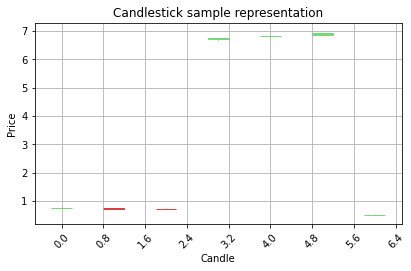

Correct prediction is Bearish
Model prediction is Bullish
LOST


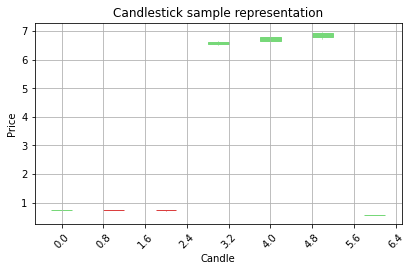

Correct prediction is Bullish
Model prediction is Bearish
LOST


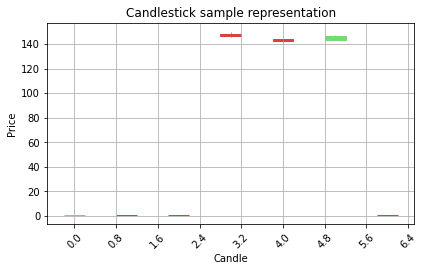

Correct prediction is Bearish
Model prediction is Bullish
LOST


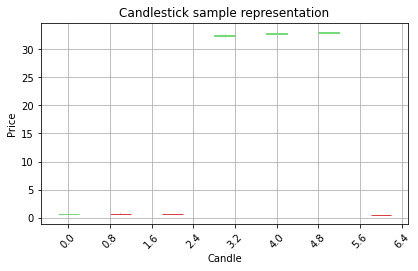

Correct prediction is Bearish
Model prediction is Bearish
WON


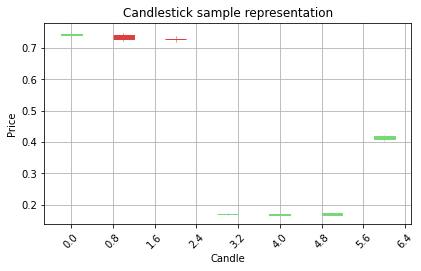

Correct prediction is Bearish
Model prediction is Bearish
WON


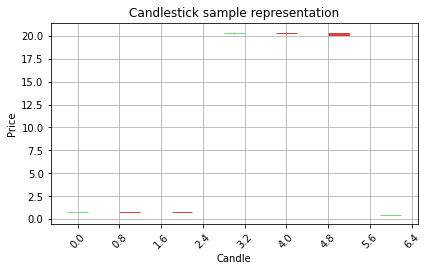

Correct prediction is Bullish
Model prediction is Bearish
LOST


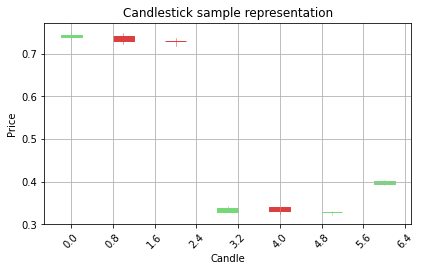

Correct prediction is Bearish
Model prediction is Bullish
LOST


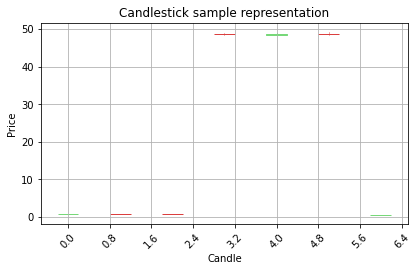

Correct prediction is Bearish
Model prediction is Bearish
WON


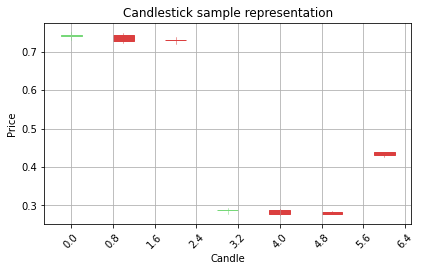

Correct prediction is Bullish
Model prediction is Bullish
WON


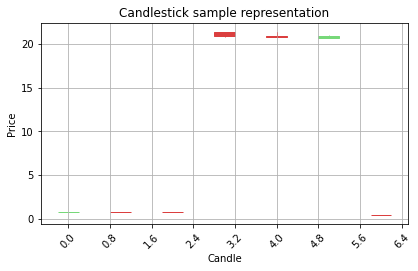

Correct prediction is Bearish
Model prediction is Bearish
WON


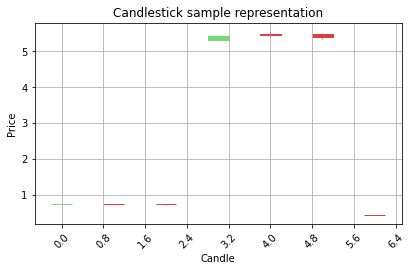

Correct prediction is Bearish
Model prediction is Bullish
LOST


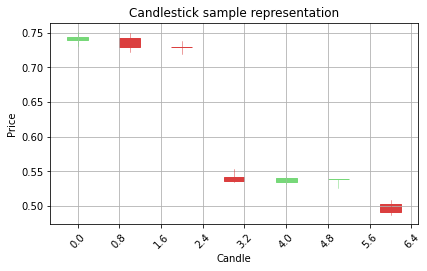

Correct prediction is Bullish
Model prediction is Bullish
WON


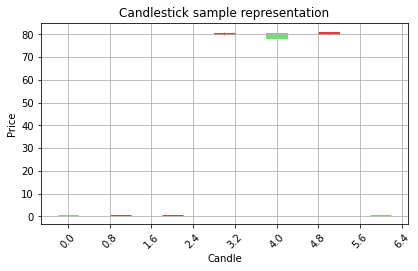

Correct prediction is Bullish
Model prediction is Bearish
LOST


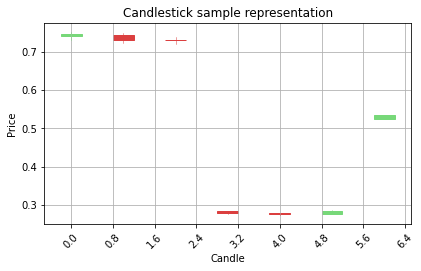

Correct prediction is Bullish
Model prediction is Bullish
WON


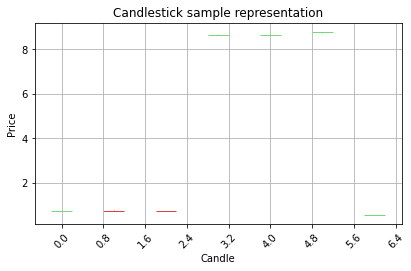

Correct prediction is Bullish
Model prediction is Bullish
WON


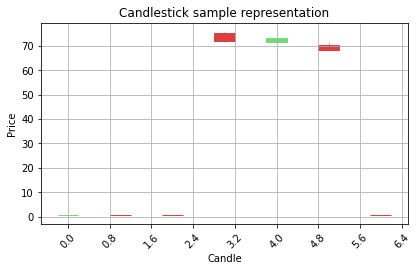

Correct prediction is Bullish
Model prediction is Bullish
WON


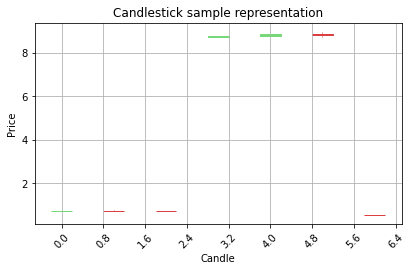

Correct prediction is Bullish
Model prediction is Bullish
WON


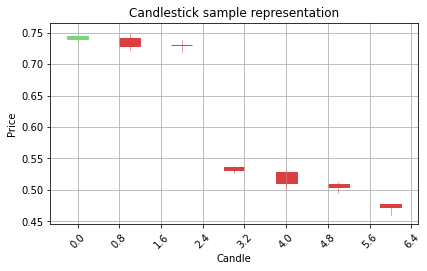

Correct prediction is Bullish
Model prediction is Bullish
WON


KeyboardInterrupt: 

In [207]:
cell_timer = MeasureTime()
counter = 0
won = 0
lost = 0
test = model.predict(X_test)
alpha_distance = 0.35

for a in test:
  
    if a > (1-alpha_distance) or a < alpha_distance :
        if Y_test[counter] == 1:print('Correct prediction is Bullish')
        if Y_test[counter] == 0:print('Correct prediction is Bearish')
        if a > (1-alpha_distance):print('Model prediction is Bullish')
        if a < alpha_distance:print('Model prediction is Bearish')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        d_arr = np.empty(( 3 ,4))
        X_test_raw[counter] = np.append(X_test_raw[counter] , df.values[counter].reshape(1,4) , axis= 0)
        d_arr = np.append(d_arr , X_test_raw[counter] , axis= 0 )
        
        graph_data_ohlc(d_arr)

    counter=counter+1
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')
cell_timer.kill()